In [ ]:
# OUVRIR LE CSV
import pandas as pd
import numpy as np

df = pd.read_csv("data/Pfitzer10-100.csv", sep=";")

# Replace comma with dot and convert to float
df["x"] = pd.to_numeric(df["x"].str.replace(",", "."), errors="coerce")
df["y"] = pd.to_numeric(df["y"].str.replace(",", "."), errors="coerce")
df["workload index"] = pd.to_numeric(
    df["workload index"].str.replace(",", "."), errors="coerce"
)

df_for_fixed_SR = df[df["current office"] == 1]

clusters = {
    str(i + 1): df_for_fixed_SR[df_for_fixed_SR[str(i + 1)] == 1][["x", "y"]].values
    for i in range(len(df_for_fixed_SR))
}

# Calculer les distances pour chaque cluster
for cluster_id, points in clusters.items():
    distances = np.linalg.norm(df[["x", "y"]].values[:, None] - points, axis=2)

    df[f"distance_to_{cluster_id}"] = distances

Dist_Matrix = df.filter(like="distance_to_").to_numpy().T

WL_Matrix = df.filter(like="workload index").to_numpy()
initial_bricks = {
    i: {
        "center_brick": df_for_fixed_SR[df_for_fixed_SR[str(i + 1)] == 1][
            "zone"
        ].values[0],
        "assigned_bricks": df[df[str(i + 1)] == 1]["zone"].to_numpy() - 1,
    }
    for i in range(len(df_for_fixed_SR))
}


100 10
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[x86] - Darwin 21.6.0 21H1123)

CPU model: Intel(R) Core(TM) i5-5350U CPU @ 1.80GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 141 rows, 1002 columns and 4912 nonzeros
Model fingerprint: 0x0ecb0a88
Variable types: 2 continuous, 1000 integer (1000 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 9.0316753
Presolve removed 1 rows and 0 columns
Presolve time: 0.01s
Presolved: 140 rows, 1002 columns, 4911 nonzeros
Variable types: 2 continuous, 1000 integer (1000 binary)

Root relaxation: objective 1.620589e+00, 427 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds 

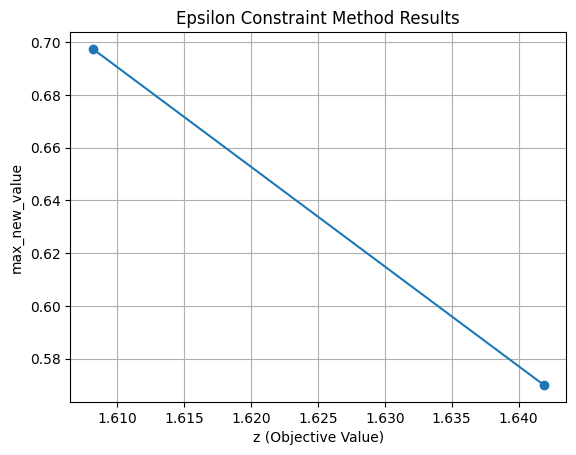

In [6]:
from gurobipy import *


def epsilon_constraint(
    Dist_Matrix, WL_Matrix, workload_range, epsilon, epsilon2, initial_bricks
):
    m = Model("brick")
    assert Dist_Matrix.shape[1] == WL_Matrix.shape[0], (
        "Mismatch in dimensions of Dist_Matrix and WL_Matrix"
    )
    assert len(initial_bricks) == Dist_Matrix.shape[0], (
        "Mismatch in dimensions of Dist_Matrix and initial_bricks"
    )
    # Create variables
    num_bricks = Dist_Matrix.shape[1]
    num_groups = Dist_Matrix.shape[0]
    print(num_bricks, num_groups)

    x = m.addVars(num_bricks, num_groups, vtype=GRB.BINARY, name="x")
    max_new_value = m.addVar(vtype=GRB.CONTINUOUS, name="max_new_value")
    z = m.addVar(name="z")

    # Set constraints
    for j in range(num_groups):
        new_brick_value = sum(
            WL_Matrix[brick] * x[brick, j]
            for brick in range(num_bricks)
            if brick + 1 not in initial_bricks[j]["assigned_bricks"]
        )
        m.addConstr(max_new_value >= new_brick_value[0])

    m.addConstrs(
        (sum(x[i, j] for j in range(num_groups)) == 1 for i in range(num_bricks))
    )
    m.addConstrs(
        (
            sum(WL_Matrix[i][0] * x[i, j] for i in range(num_bricks))
            <= workload_range[1]
            for j in range(num_groups)
        )
    )
    m.addConstrs(
        (
            sum(WL_Matrix[i][0] * x[i, j] for i in range(num_bricks))
            >= workload_range[0]
            for j in range(num_groups)
        )
    )

    m.addConstrs(
        (
            z >= sum(Dist_Matrix[j, i] * x[i, j] for i in range(num_bricks))
            for j in range(num_groups)
        )
    )

    m.addConstr(max_new_value <= epsilon2)

    # Set objective
    m.setObjective(z + epsilon * max_new_value, GRB.MINIMIZE)

    # Optimize the model
    m.optimize()

    return m, z, max_new_value


def go_epsilon_constraint(
    Dist_Matrix, WL_Matrix, initial_bricks, epsilon, workload_range
):
    epsilon2 = np.inf
    list_model = []
    m, z, max_new_value = epsilon_constraint(
        Dist_Matrix, WL_Matrix, workload_range, epsilon, epsilon2, initial_bricks
    )
    while m.status == GRB.OPTIMAL:
        epsilon2 = max_new_value.X - 0.1
        list_model.append((z.X, max_new_value.X))
        m, z, max_new_value = epsilon_constraint(
            Dist_Matrix, WL_Matrix, workload_range, epsilon, epsilon2, initial_bricks
        )

    return list_model


workload_ranges = [(0.8, 1.2)]
for workload_range in workload_ranges:
    list = go_epsilon_constraint(
        Dist_Matrix, WL_Matrix, initial_bricks, 0.1, workload_range
    )

    import matplotlib.pyplot as plt

    # Extract z and max_new_value from the list
    z_values, max_new_values = zip(*list)

    # Plot the values
    plt.plot(z_values, max_new_values, marker="o")
    plt.xlabel("z (Objective Value)")
    plt.ylabel("max_new_value")
    plt.title("Epsilon Constraint Method Results")
    plt.grid(True)
plt.show()

In [ ]:



def epsilon_constraint(
    Dist_Matrix, WL_Matrix, workload_range, epsilon, epsilon2, initial_bricks
):
    m = Model("brick")

    # Create variables
    num_bricks = Dist_Matrix.shape[1]
    num_groups = len(initial_bricks)
    print(num_bricks, num_groups)

    x = m.addVars(num_bricks, num_groups, vtype=GRB.BINARY, name="x")
    max_new_value = m.addVar(vtype=GRB.CONTINUOUS, name="max_new_value")

    z = m.addVar(name="z")

    # Set constraints
    for j in range(num_groups):
        new_brick_value = sum(
            WL_Matrix[brick] * x[brick, j]
            for brick in range(num_bricks)
            if brick + 1 not in initial_bricks[j]["assigned_bricks"]
        )[0]
        m.addConstr(max_new_value >= new_brick_value)

    m.addConstrs(
        (sum(x[i, j] for j in range(num_groups)) == 1 for i in range(num_bricks))
    )

    m.addConstrs(
        (
            sum(WL_Matrix[i][0] * x[i, j] for i in range(num_bricks)) <= workload_range[1]
            for j in range(num_groups)
        )
    )
    m.addConstrs(
        (
            sum(WL_Matrix[i][0] * x[i, j] for i in range(num_bricks)) >= workload_range[0]
            for j in range(num_groups)
        )
    )

    m.addConstr(
        z
        == sum(
            Dist_Matrix[j, i] * x[i, j]
            for i in range(num_bricks)
            for j in range(num_groups)
        )
    )
    m.addConstr(max_new_value <= epsilon2)

    # Set objective
    m.setObjective(z + epsilon * max_new_value, GRB.MINIMIZE)

    # Optimize the model
    m.optimize()

    return m, z, max_new_value


def go_epsilon_constraint(
    Dist_Matrix, WL_Matrix, initial_bricks, epsilon, workload_range
):
    epsilon2 = np.inf
    list_model = []
    m, z, max_new_value = epsilon_constraint(
        Dist_Matrix, WL_Matrix, workload_range, epsilon, epsilon2, initial_bricks
    )
    while m.status == GRB.OPTIMAL:
        epsilon2 = max_new_value.X - 0.001
        list_model.append((z.X, max_new_value.X))
        m, z, max_new_value = epsilon_constraint(
            Dist_Matrix, WL_Matrix, workload_range, epsilon, epsilon2, initial_bricks
        )

    return list_model


workload_ranges = [(0.8, 1.2), (0.85, 1.15), (0.9, 1.1)]
for workload_range in workload_ranges:
    list = go_epsilon_constraint(
        Dist_Matrix, WL_Matrix, initial_bricks, 0.001, workload_range
    )

    import matplotlib.pyplot as plt

    # Extract z and max_new_value from the list
    z_values, max_new_values = zip(*list)

    # Plot the values
    plt.plot(z_values, max_new_values, marker="o")
    plt.xlabel("z (Objective Value)")
    plt.ylabel("max_new_value")
    plt.title("Epsilon Constraint Method Results")
    plt.grid(True)
plt.show()

100 10


TypeError: 'Var' object is not subscriptable